# Figure_4_ArgR

In [3]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

## Load the data from ./Data/ folder

In [4]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [5]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [6]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [51]:
Regulon_DB_P1K = pd.read_csv('../Data/Regulon_DB_P1K.csv', index_col=0)

In [7]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

In [37]:
iM_table = pd.read_csv('../Data/iM_table.csv', index_col = 0)

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [8]:
P1K_M = precise1k.M

In [9]:
P1K_A = precise1k.A

In [10]:
P1K_X = precise1k.X

In [11]:
P1K_log_tpm = precise1k.log_tpm

### RegulonDB TRN

In [12]:
RegulonDB_TRN

,FecI,FliA,RpoD,RpoE,RpoH,RpoN,RpoS,AcrR,Ada,AdiY,...,YefM,YefMB,YgiV,YhaJ,YiaU,YjjQ,YqhC,ZntR,ZraR,Zur
aaeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abgA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
zraP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# dual regulator example 1: astCADBE - ArgR/NtrC
- 3D plot
- sample specific plotas

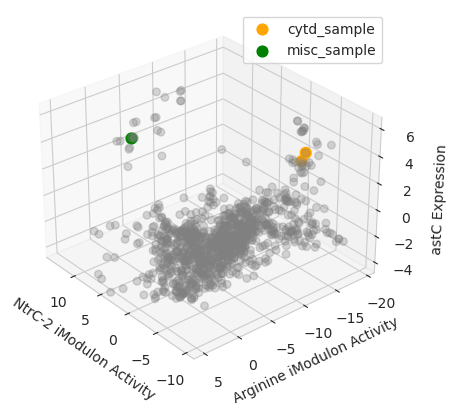

In [14]:
# 3D plot of NtrC, Arginine, and astC

# special samples
s1_cytd = ['p1k_00167','p1k_00168']
s2_misc = ['p1k_00049']

# data
ntrcA = precise1k.A.loc['NtrC-2'].tolist()
argA = precise1k.A.loc['Arginine'].tolist()
astC = precise1k.X.loc['b1748'].tolist()

# make plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ntrcA, argA, astC, alpha = 0.3, color = 'gray',s=30)
ax.scatter(precise1k.A.loc['NtrC-2'][s1_cytd].tolist(), precise1k.A.loc['Arginine'][s1_cytd].tolist(), precise1k.X.loc['b1748'][s1_cytd].tolist(),alpha =1, color = 'orange',s=60,label = 'cytd_sample')
ax.scatter(precise1k.A.loc['NtrC-2'][s2_misc].tolist(), precise1k.A.loc['Arginine'][s2_misc].tolist(), precise1k.X.loc['b1748'][s2_misc].tolist(),alpha =1, color = 'green',s=60, label = 'misc_sample')
ax.set_ylim([min(argA), 6])

# Set labels for each axis
ax.set_xlabel('NtrC-2 iModulon Activity')
ax.set_ylabel('Arginine iModulon Activity')
ax.set_zlabel('astC Expression')
ax.legend()

ax.view_init(elev=30, azim=140)

# Display the plot
plt.show()

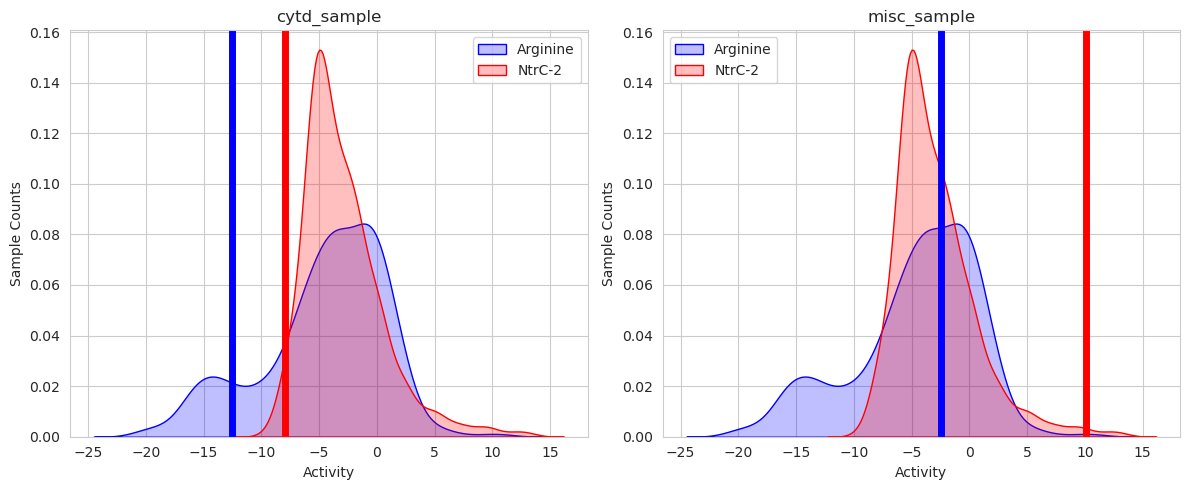

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

samples = [['p1k_00167','p1k_00168'],'p1k_00049']

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for Sample 1
sns.kdeplot(argA, color='blue', label='Arginine', ax=axs[0], fill=True)
sns.kdeplot(ntrcA, color='red', label='NtrC-2', ax=axs[0], fill=True)
axs[0].axvline(precise1k.A[samples[0]].loc['Arginine'].mean(), color='blue', linewidth=5)
axs[0].axvline(precise1k.A[samples[0]].loc['NtrC-2'].mean(), color='red', linewidth=5)
axs[0].set_xlabel("Activity")
axs[0].set_ylabel("Sample Counts")
axs[0].legend()
axs[0].set_title("cytd_sample")

# Plot for Sample 2
sns.kdeplot(argA, color='blue', label='Arginine', ax=axs[1], fill=True)
sns.kdeplot(ntrcA, color='red', label='NtrC-2', ax=axs[1], fill=True)
axs[1].axvline(precise1k.A[samples[1]].loc['Arginine'], color='blue', linewidth=5)
axs[1].axvline(precise1k.A[samples[1]].loc['NtrC-2'], color='red', linewidth=5)
axs[1].set_xlabel("Activity")
axs[1].set_ylabel("Sample Counts")
axs[1].legend()
axs[1].set_title("misc_sample")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# ArgR Gene-Gene Correlation Heatmap

### Filter and Prepare Data

In [17]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession-1' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession-1' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Set 'Gene Name' as the new index and drop the 'Accession-1' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [18]:
def get_genes_for_iM(df, regulator):

    if regulator not in df.columns:
        raise ValueError(f"Regulator '{regulator}' not found in DataFrame columns.")
    
    # Get the list of genes where the value in the specified column is 1
    genes_in_regulon = df.index[df[regulator] == 1].tolist()
    
    return genes_in_regulon

In [19]:
P1K_log_tpm_gene_name = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

In [20]:
P1K_Gene_Presence_Matrix_gene_name = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

In [22]:
Regulon_DB_TRN_filtered = RegulonDB_TRN.loc[RegulonDB_TRN.index.intersection(P1K_log_tpm_gene_name.index)]

### Plotting Functions

In [23]:
def plot_regulon_corr_heatmap_with_clustering(regulator, regulon_df, expression_df, gene_list, matrix=True, figure_size=(5, 4)):
    # Find the genes in the regulon by the given regulator
    genes_in_regulon = regulon_df.index[regulon_df[regulator] == 1].tolist()
    
    # Union of genes_in_regulon and gene_list
    union_genes = list(set(genes_in_regulon).union(set(gene_list)))
    
    # Subset the expression DataFrame for these genes
    expression_subset = expression_df.loc[union_genes]
    
    # Create a correlation matrix of expression for these genes
    correlation_matrix = expression_subset.transpose().corr()
    
    # Calculate the average of correlation values
    avg_corr_value = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)].mean()

    # Perform hierarchical clustering on the rows
    linkage_matrix = linkage(correlation_matrix, method='average')
    dendrogram_order = leaves_list(linkage_matrix)
    clustered_corr_matrix = correlation_matrix.iloc[dendrogram_order, dendrogram_order]

    # Get the ordered list of genes after clustering
    clustered_genes = clustered_corr_matrix.index

    # Plot the correlation matrix as a heatmap with clustering
    plt.figure(figsize=figure_size)
    sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title(f'Corr Heatmap for {regulator} Regulon - Avg Corr: {avg_corr_value:.3f}')
    
    # Add category boxes at the diagonal
    def add_category_box(start_idx, end_idx, color):
        width = end_idx - start_idx + 1
        rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

    ax = plt.gca()
    current_category = None
    start_idx = 0

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
            current_category = category
            current_category_color = color
            start_idx = idx

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)

    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()
    
    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.font_manager as fm

def plot_regulon_corr_heatmap_with_clustering(regulator, regulon_df, expression_df, gene_list, matrix=True, figure_size=(5, 4), save_path=None):
    # Define custom font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Find the genes in the regulon by the given regulator
    genes_in_regulon = regulon_df.index[regulon_df[regulator] == 1].tolist()
    
    # Union of genes_in_regulon and gene_list
    union_genes = list(set(genes_in_regulon).union(set(gene_list)))
    
    # Subset the expression DataFrame for these genes
    expression_subset = expression_df.loc[union_genes]
    
    # Create a correlation matrix of expression for these genes
    correlation_matrix = expression_subset.transpose().corr()
    
    # Calculate the average of correlation values
    avg_corr_value = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)].mean()

    # Perform hierarchical clustering on the rows
    linkage_matrix = linkage(correlation_matrix, method='average')
    dendrogram_order = leaves_list(linkage_matrix)
    clustered_corr_matrix = correlation_matrix.iloc[dendrogram_order, dendrogram_order]

    # Get the ordered list of genes after clustering
    clustered_genes = clustered_corr_matrix.index

    # Plot the correlation matrix as a heatmap with clustering
    plt.figure(figsize=figure_size)
    sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=False)

    # Remove all ticks (both x and y)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title with custom font
    # plt.title(f'Corr Heatmap for {regulator} Regulon - Avg Corr: {avg_corr_value:.3f}', fontproperties=font_prop)

    # Set x and y labels with custom font
    ax.set_xlabel("Gene Name", fontproperties=font_prop)
    ax.set_ylabel("Gene Name", fontproperties=font_prop)

    # Add category boxes at the diagonal
    def add_category_box(start_idx, end_idx, color):
        width = end_idx - start_idx + 1
        rect = Rectangle((start_idx, start_idx), width, width, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

    current_category = None
    start_idx = 0
    category_genes = []

    for idx, gene in enumerate(clustered_genes):
        if gene in genes_in_regulon and gene in gene_list:
            category = 'Overlap'
            color = 'lightgreen'
        elif gene in genes_in_regulon:
            category = 'Regulons'
            color = 'black'
        elif gene in gene_list:
            category = 'iModulons'
            color = 'yellow'
        else:
            category = None
            color = 'black'

        if category != current_category:
            if current_category is not None:
                add_category_box(start_idx, idx - 1, current_category_color)
                # Print genes in the current category
                print(f"{current_category} genes from index {start_idx} to {idx - 1}:")
                print(category_genes)
                category_genes = []
            current_category = category
            current_category_color = color
            start_idx = idx

        category_genes.append(gene)

    if current_category is not None:
        add_category_box(start_idx, len(clustered_genes) - 1, current_category_color)
        # Print genes in the final category
        print(f"{current_category} genes from index {start_idx} to {len(clustered_genes) - 1}:")
        print(category_genes)

    # Create custom legend with custom font
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Regulons'),
        Line2D([0], [0], color='yellow', lw=2, label='iModulons'),
        Line2D([0], [0], color='lightgreen', lw=2, label='Overlap of iModulons and Regulons')
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop=font_prop)

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

    if not matrix:
        clustered_corr_matrix = None

    return clustered_corr_matrix


### Figure - Regulon ArgR

In [25]:
ArgR_iM_Genes = get_genes_for_iM(P1K_Gene_Presence_Matrix_gene_name, 'Arginine')

Overlap genes from index 0 to 1:
['artJ', 'argF']
iModulons genes from index 2 to 2:
['xynR']
Overlap genes from index 3 to 6:
['hisJ', 'hisQ', 'hisM', 'hisP']
Regulons genes from index 7 to 7:
['potF']
Overlap genes from index 8 to 11:
['artM', 'artI', 'artP', 'artQ']
Regulons genes from index 12 to 16:
['yraQ', 'waaA', 'argR', 'stpA', 'gltF']
Overlap genes from index 17 to 17:
['argE']
iModulons genes from index 18 to 18:
['dtpD']
Overlap genes from index 19 to 27:
['argD', 'argA', 'argI', 'argH', 'argG', 'argB', 'argC', 'carB', 'carA']
Regulons genes from index 28 to 45:
['lysO', 'cvpA', 'gltB', 'gltD', 'lrp', 'aroP', 'eutS', 'astE', 'astB', 'astD', 'astA', 'astC', 'ykgA', 'hchA', 'dacC', 'dps', 'pfkB', 'ftsZ']
iModulons genes from index 46 to 46:
['caiF']
Regulons genes from index 47 to 62:
['yffB', 'puuB', 'pyrL', 'yaaU', 'mukE', 'rpsO', 'aroK', 'ydgI', 'rimP', 'pnp', 'infB', 'nusA', 'truB', 'rbfA', 'yhcC', 'yfcC']
iModulons genes from index 63 to 63:
['asnA']
Regulons genes from 

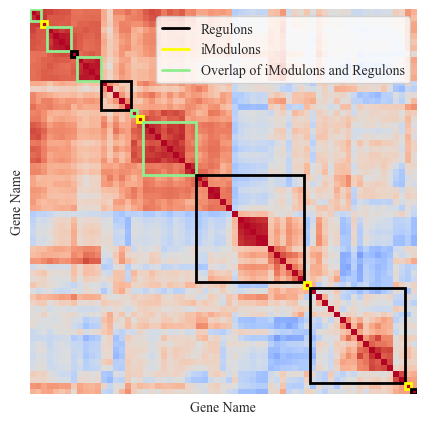

In [26]:
plot_regulon_corr_heatmap_with_clustering('ArgR', Regulon_DB_TRN_filtered, P1K_log_tpm_gene_name, ArgR_iM_Genes, matrix = False, figure_size = (5,5))

# Bitome analysis of binding sites

Look at the binding site similarity in different parts of the argR regulon/iModulon
Does it support the idea that ICA works when the binding sites in the regulon have similar properties?


## Import packages and data

In [ ]:
import itertools
from pathlib import Path
import sys

from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.io import load_json_model, save_to_json

sys.path.append('../../bitome2/')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *

In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [ ]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [ ]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [ ]:
ica_data = load_json_model('../data/precise2.json.gz')

## Motif score analysis

In [ ]:
# modify legacy PSSM format into Bitome 2 format
tf_pwm_db = rpwm('../data/motif_pwm_db.txt')
flhdc_pwm_old = tf_pwm_db['FlhDC']
flhdc_pssm = {base: [pos_dict[base] for pos_dict in flhdc_pwm_old] for base in 'ATCG'}

flhdc1_genes = ica_data.view_imodulon('FlhDC-1')['gene_name'].values
flhdc2_genes = ica_data.view_imodulon('FlhDC-2')['gene_name'].values
all_flhdc_genes = set(flhdc1_genes).union(flhdc2_genes)

gene2score = {}
for flhdc_gene in all_flhdc_genes:
    tus_for_gene = mg1655._gene_to_tus[ica_data.name2num(flhdc_gene)]
    gene_tu_df = mg1655.tu_table.loc[tus_for_gene]
    gene_tu_df_tss = gene_tu_df[gene_tu_df['tss'].notna()]
    scores = []
    for tu_id, tu_row in gene_tu_df_tss.iterrows():
        best_motif_match = mg1655.promoter_motif_search(tu_row.tss, tu_row.strand, flhdc_pssm)
        scores.append(best_motif_match.log_odds.values[0])
    if scores:
        gene2score[flhdc_gene] = np.mean(scores)

In [ ]:
flhdc1_df = ica_data.view_imodulon('FlhDC-1')
flhdc1_df['score'] = flhdc1_df['gene_name'].apply(lambda gn: gene2score.get(gn, None))
flhdc1_w_motif = flhdc1_df[flhdc1_df['score'].notna()]
flhdc1_w_motif = flhdc1_w_motif.set_index('gene_name')

_, ax = plt.subplots(figsize=(8, 6))

scatterplot(
    flhdc1_w_motif['score'], flhdc1_w_motif['gene_weight'],
    xlabel='FlhDC Motif Log-Odds Score',
    ylabel='FlhDC-1 Gene Weight',
    show_labels=True,
    fit_line=True,
    legend=False,
    ax=ax
)

Can we find known ArgP binding sites according to RegulonDB? 28252 28271, and 28272 28291

In [ ]:
bitome_genbank.motif_search(28000, 29000, +1, argp_pssm, n_best_matches=5)

Motif Matching near TSS

In [ ]:
bitome_genbank.promoter_motif_search(28288, 1, argp_pssm, n_best_matches=5)

This helpful function returns a DataFrame of all features in a given range

In [ ]:
bitome_genbank.features_in_range(1, 10000)

Getting Binding sites from the Bitome

In [ ]:
bitome_tfbs_df = mg1655.tfbs_table[mg1655.tfbs_table['left'].notna()]
bitome_tfbs_df['source'] = 'RegulonDB'
bitome_tfbs_df.head()

# M augmentation

### useful functions

In [27]:
def get_genes_in_component(df, component):
    # Filtering the dataframe for True values in the specified component
    # The result is a series of True/False values for each row
    gene_presence_in_component = df[str(component)]
    
    # Filtering the series to only include rows (genes) where the value is True
    genes_in_component = gene_presence_in_component[gene_presence_in_component]
    
    # The indices of the series now correspond to the gene names, 
    # so we can return them as a list
    return genes_in_component.index.tolist()

In [28]:
def calculate_and_filter_correlations(gene_ids, regulator, log_tpm_precise_1k, A_p1k, iM_table, corr_threshold=0.5):
    """
    Calculate correlation between gene expression and regulator activity for each gene,
    convert the result to a dataframe, and filter out rows with correlation smaller than the threshold.

    """
    # Calculate correlations
    regulator_activity = A_p1k.loc[iM_table[iM_table['regulator_readable'] == regulator].index.tolist()[0]]

    correlation_dict = {}
    for gene_id in gene_ids:
        gene_expression = log_tpm_precise_1k.loc[gene_id]
        correlation = gene_expression.corr(regulator_activity)
        correlation_dict[gene_id] = correlation

    # Convert to dataframe and filter
    df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Correlation'])
    df = df[df['Correlation'] >= corr_threshold]

    return df.index.to_list()

In [52]:
def get_gene_ids(dataframe, regulator):
    
    # Get all gene_ids for a specific regulator
    gene_ids = dataframe[dataframe['regulator'] == regulator]['gene_id'].tolist()
    return gene_ids

In [30]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def venn_plot_and_genes(regulon, genes, regulator):
    """
    Create a Venn diagram comparing the genes in the given dataframe with the original genes,
    and print the genes in each subset of the diagram.
    
    """
    # Convert to sets
    new_genes = set(regulon)
    original_genes = set(genes)

    # Plot Venn diagram
    plt.figure(figsize=(4, 3))
    venn2([new_genes, original_genes], set_labels = ('Regulon Genes', 'Updated Genes'))
    plt.title(f'Venn Diagram for {regulator}')
    plt.show()

    # Print gene lists
    # Only in filtered_genes
    only_in_new = new_genes - original_genes
    #print("Only in Regulon:", only_in_new)

    # Only in original_genes
    only_in_original = original_genes - new_genes
    #print("Only in updated genes:", only_in_original)

    # Intersection of both
    intersection = new_genes & original_genes
    #print("In both Regulon and updated genes:", intersection)

In [31]:
def explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, genes_list):
    # Copy the dataframe to avoid altering the original data
    M_p1k_copied = M_p1k.copy()
    
    # Set the values for other genes to 0 for specific component
    M_p1k_copied.loc[~M_p1k_copied.index.isin(genes_list), str(component)] = 0
    
    # Get samples that exist in both dataframes
    common_samples = list(set(A_p1k.columns) & set(log_tpm_precise_1k.columns))

    # Subset dataframes by these common samples
    A_p1k = A_p1k[common_samples]
    log_tpm_precise_1k = log_tpm_precise_1k[common_samples]

    # Center the log_tpm_precise_1k dataframe
    centered = log_tpm_precise_1k.subtract(log_tpm_precise_1k.mean(axis=0), axis=1)

    # Initialize variables
    base_err = np.linalg.norm(centered.values) ** 2

    # Compute component contribution
    ma_arr = np.dot(
        M_p1k_copied.loc[:, str(component)].values.reshape(len(M_p1k), 1),
        A_p1k.loc[component, :].values.reshape(1, len(common_samples)),
    )

    # Compute variance explained by this component only
    sa_err = np.linalg.norm(ma_arr - centered.values) ** 2
    rec_var = (1 - sa_err / base_err)
    explained_variance = np.clip(rec_var, 0, 1)

    return explained_variance

In [32]:
def compute_EV_diff_for_each_gene(A_p1k, M_p1k, log_tpm_precise_1k, component, original_genes, regulon_genes):
    # Initialize an empty dataframe to store the results
    explained_variance_change = pd.DataFrame(columns=['gene_name', 'change_explained_variance'])
    
    # Initialize a copy of original_genes to hold the new genes
    new_genes = original_genes.copy()

    # Loop over the regulon_genes list
    for gene in regulon_genes:
        # Check if the gene is not in the original_genes list
        if gene not in original_genes:
            # Add the gene to the original_genes list
            original_genes.append(gene)

            # Compute the explained variance with the new gene added
            new_variance = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, original_genes)

            # Remove the gene from the original_genes list
            original_genes.remove(gene)

            # Compute the explained variance without the new gene
            original_variance = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, original_genes)

            # Compute the change in explained variance
            change_variance = new_variance - original_variance

            # Append the result to the dataframe
            explained_variance_change = explained_variance_change.append({'gene_name': gene, 'change_explained_variance': change_variance}, ignore_index=True)

            # If the change in variance is positive, add the gene to new_genes
            if change_variance > 0:
                new_genes.append(gene)

    # Sort the dataframe by the change_explained_variance column in descending order
    explained_variance_change = explained_variance_change.sort_values(by='change_explained_variance', ascending=False)

    # Reset the index of the dataframe
    explained_variance_change = explained_variance_change.reset_index(drop=True)

    # Return the resulting dataframe and the new list of genes
    return explained_variance_change, new_genes

In [33]:
def compute_and_print_variances(A_p1k, M_p1k, log_tpm_precise_1k, iM_table, original_genes, regulon_genes, new_genes):
    component = iM_table[iM_table['regulator_readable'] == 'ArgR'].index.tolist()[0]
    original_genes_variance = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, original_genes)
    regulon_genes_variance = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, regulon_genes)
    component_original = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, log_tpm_precise_1k.index.to_list())
    new_genes_variance = explained_variance_subset_genes(A_p1k, M_p1k, log_tpm_precise_1k, component, new_genes)

    print("Variance explained by original_genes: ", original_genes_variance)
    print("Variance explained by regulon_genes: ", regulon_genes_variance)
    print("Variance explained by original component: ", component_original)
    print("Variance explained by new_genes: ", new_genes_variance)

In [45]:
ArgR_original_genes = get_genes_in_component(P1K_Gene_Presence_Matrix, list(iM_table[iM_table['regulator_readable'] == 'ArgR']['name'])[0])
print(ArgR_original_genes)

['b0032', 'b0033', 'b0034', 'b0272', 'b0273', 'b0709', 'b0860', 'b0861', 'b0862', 'b0863', 'b0864', 'b2306', 'b2307', 'b2308', 'b2309', 'b2818', 'b3172', 'b3359', 'b3744', 'b3957', 'b3958', 'b3959', 'b3960', 'b4254']


In [53]:
ArgR_regulon_genes = get_gene_ids(Regulon_DB_P1K, "ArgR")
print(ArgR_regulon_genes)

['b3960', 'b3172', 'b0273', 'b3957', 'b3166', 'b3359', 'b4254', 'b3959', 'b2818', 'b3958', 'b3165', 'b3170', 'b0860', 'b0861', 'b0864', 'b0862', 'b1747', 'b1745', 'b1748', 'b1746', 'b1744', 'b0032', 'b0863', 'b0033', 'b3212', 'b3213', 'b3214', 'b2309', 'b2307', 'b2306', 'b2308', 'b3168', 'b0874', 'b3169', 'b3164', 'b3167', 'b3237', 'b0923', 'b1723', 'b2669', 'b1967', 'b1605', 'b0045', 'b3633', 'b2298', 'b2313', 'b0839', 'b1301', 'b0854', 'b0812', 'b0300', 'b4077', 'b0112', 'b2471', 'b3151', 'b3211', 'b0889', 'b3390', 'b4246', 'b2462', 'b0095']


In [23]:
ArgR_genes_from_corr = calculate_and_filter_correlations(ArgR_regulon_genes, "ArgR", log_tpm_precise_1k, A_p1k, iM_table, corr_threshold=0.5)
print(ArgR_genes_from_corr)

['b3960', 'b3172', 'b0273', 'b3957', 'b3359', 'b4254', 'b3959', 'b2818', 'b3958', 'b0860', 'b0032', 'b0033', 'b3212', 'b3213', 'b3214', 'b2309', 'b2307', 'b2306', 'b2308', 'b0874', 'b3237', 'b2313', 'b0112', 'b3151', 'b0889']


In [24]:
ArgR_corr_genes = set(ArgR_genes_from_corr+ArgR_original_genes)

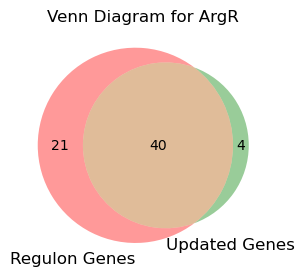

Variance explained by original_genes:  0.007256095475200897
Variance explained by regulon_genes:  0.0069551261356307625
Variance explained by original component:  0.007572620446356759
Variance explained by new_genes:  0.007727355554288162


In [25]:
explained_variance_change, ArgR_new_genes = compute_EV_diff_for_each_gene(A_p1k, M_p1k, log_tpm_precise_1k, iM_table[iM_table['regulator_readable'] == 'ArgR'].index.tolist()[0], ArgR_original_genes, ArgR_regulon_genes)
venn_plot_and_genes(ArgR_regulon_genes, ArgR_new_genes, 'ArgR')
compute_and_print_variances(A_p1k, M_p1k, log_tpm_precise_1k, iM_table, ArgR_original_genes, ArgR_regulon_genes, ArgR_new_genes)

In [30]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def venn_plot_and_genes_original(regulon, genes, regulator):
    """
    Create a Venn diagram comparing the genes in the given dataframe with the original genes,
    and print the genes in each subset of the diagram.
    
    """
    # Convert to sets
    new_genes = set(regulon)
    original_genes = set(genes)

    # Plot Venn diagram
    plt.figure(figsize=(4, 3))
    venn2([new_genes, original_genes], set_labels = ('Regulon Genes', 'Original Genes'))
    plt.title(f'Venn Diagram for {regulator}')
    plt.show()

    # Print gene lists
    # Only in filtered_genes
    only_in_new = new_genes - original_genes
    #print("Only in Regulon:", only_in_new)

    # Only in original_genes
    only_in_original = original_genes - new_genes
    #print("Only in updated genes:", only_in_original)

    # Intersection of both
    intersection = new_genes & original_genes
    #print("In both Regulon and updated genes:", intersection)

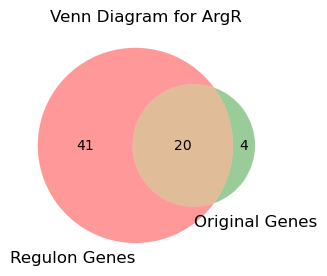

In [31]:
venn_plot_and_genes_original(ArgR_regulon_genes, ArgR_original_genes, 'ArgR')

In [33]:
print(explained_variance_change)

   gene_name  change_explained_variance
0      b4246               7.641517e-05
1      b0854               7.146228e-05
2      b3212               6.455102e-05
3      b3213               4.682758e-05
4      b0874               4.118248e-05
5      b2313               3.615611e-05
6      b1301               2.636979e-05
7      b3214               2.586112e-05
8      b3151               2.314424e-05
9      b2471               1.941619e-05
10     b0889               1.112272e-05
11     b3237               9.605101e-06
12     b2462               7.051721e-06
13     b1745               4.323461e-06
14     b1744               2.952860e-06
15     b0045               2.166561e-06
16     b3170               1.585728e-06
17     b3390               9.476038e-07
18     b3169               1.140467e-07
19     b0095               4.287580e-09
20     b3165              -3.656540e-08
21     b3168              -5.771196e-08
22     b3164              -8.722684e-08
23     b3167              -1.008441e-07


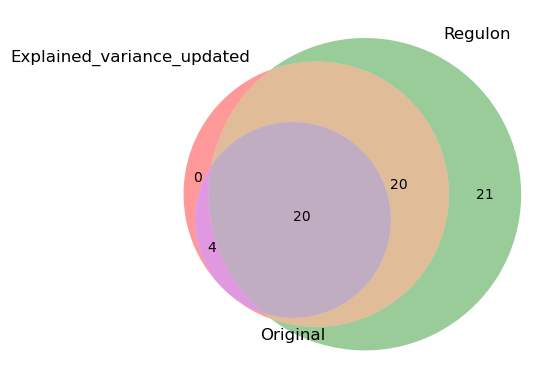

In [38]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Create a dictionary where keys are the names of the gene lists
# and values are the gene lists converted to set data type
gene_sets = {'Explained_variance_updated': set(ArgR_new_genes), 'Regulon': set(ArgR_regulon_genes), 'Original': set(ArgR_original_genes)}

# Create the Venn diagram
venn3([set(i) for i in gene_sets.values()], set_labels = gene_sets.keys())

# Display the plot
plt.show()